# Artificial Intelligence Course - Fall 1402
## Computer Assignment #2 - Reinforcement Learning
### Mahdi Noori 810100231

# Table of Contents

- [Part 1: Value Iteration & Policy Iteration Algorithms](#1)
    - [َQuestion 1:](#1-0)
    - [َQuestion 2:](#1-1)
    - [َQuestion 3:](#1-12)
    - [َQuestion 4:](#1-2)
    - [َQuestion 5:](#1-3)
        - [Value Iteration](#1-3-1)
        - [Policy Iteration](#1-3-2)
    - [َQuestion 6:](#1-4)
        - [Value Iteration](#1-4-1)
        - [Policy Iteration](#1-4-2)
- [Part 2: Q-Learning Algorithm](#2)
    - [َQuestion 8:](#2-1)
    - [َQuestion 9:](#2-2)
    - [َQuestion 10:](#2-3)

In [4]:
# import
import numpy as np
import gym
import matplotlib.pyplot as plt
import gymnasium
import pygame
from helper import table_plot_policy,table_plot_values,simulate_frozen_lake,plot_mean_values,simulate_taxi
import random
import time

<a name='1'></a>
## Part 1: Value Iteration & Policy Iteration Algorithms

In [3]:
env = gym.make('FrozenLake-v1',render_mode="rgb_array", desc=None, map_name="4x4", is_slippery=False)

you can see the environment in each step by render command :


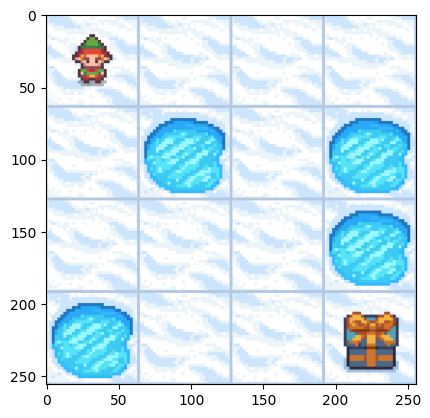

In [4]:
# get familiar with the environment
print("you can see the environment in each step by render command :")
env.reset()
image=env.render()
plt.imshow(image)
plt.show()

In [5]:
# Total no. of states
env.observation_space.n

16

In [6]:
# Total no. of actions
env.action_space.n

4

<a name='1-0'></a>
### Question 1:

Value iteration is an algorithm used to solve Markov decision processes. The algorithm iteratively updates a value function that represents the expected long-term return from each state. By considering the rewards and expected values of previous states, it determines the optimal values and policies for each state. The algorithm continues until the values converge, indicating the optimal solution. this algorithm uses Bellman equation for updating its state values shown bellow for each step.
$$ V_{k+1}(s) =  max_a\displaystyle\sum_{s'} \biggl[T(s,a,s') \Bigl( R(s,a,s')+\gamma V_k(s')\Bigr)\biggr]$$
The value iteration algorithm works as follows :
1. Initialize the value function for all states.
2. Iterate over all states and update the value function using the Bellman equation, which calculates the expected long-term rewards for each state-action pair.
3. Repeat step 2 until the values converge (the change in values is below a threshold. in the code is $\theta$ ).
4. Extract the optimal policy by selecting the action with the highest expected value for each state.


<a name='1-1'></a>
### Question 2:

In this part i just added the bellman equation in the specified section.
I also added ```get_final_policy``` function which finds the optimal policy based on the defined function ```get_optimal_policy``` for each state and then returned it.

In [7]:
class ValueIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.num_of_steps=0

    def value_estimation(self):
        self.delta = np.inf

        while(self.delta > self.theta):
            self.num_of_steps+=1
            self.delta = 0

            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                for action in range(self.env.action_space.n):
                    action_value = 0
                    for probability, next_state, reward, done in self.env.P[state][action]:
                        action_value += (probability)*(reward+(self.discount_factor*self.state_values[next_state]))
                    self.q_values[state, action] = action_value

                self.state_values[state] = np.max(self.q_values[state,:])

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])

    def take_action(self, action):
        next_state, reward, done, _,_ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state,:])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state = self.env.reset()
        return initial_state
    
    # Added By Me
    def get_final_policy(self):
        return np.array(list(map(lambda y: self.get_optimal_policy(y),list(range(self.env.observation_space.n)))))
    

<a name='1-12'></a>
### Question 3:

Policy iteration is an MDP as well. it consists of two main parts: 
- policy evaluation 
- policy improvement 

In policy evaluation, the algorithm iteratively calculates the expected values of states based on the current policy. it uses the bellman equation for this section.

In policy improvement, the algorithm updates the policy by selecting actions that maximize the expected value in each state. This step tries to improve the policy.

The algorithm alternates between policy evaluation and policy improvement until convergence. it converges when the policy is stable. the algorithm guarantees optimal policy but not that accurate at state values.


The policy iteration algorithm works as follows :
1. Initialize a policy for all states.
2. Evaluate the value function under the current policy by iterating until convergence.
3. Improve the policy by selecting the action with the highest expected value for each state.
4. Repeat steps 2 and 3 until the policy has converged to the optimal policy.


<a name='1-2'></a>
### Question 4:

In this section like before i just added the definition of bellman equation in remarked parts.

In [8]:
class PolicyIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.policy = np.random.randint(self.env.action_space.n, size=self.env.observation_space.n) # initial policy
        self.policy_stable = False
        self.num_of_steps=0

    def policy_evaluation(self):
        self.delta = np.inf
        while(self.delta >= self.theta):
            self.delta = 0
            
            for state in range(self.env.observation_space.n):
                v = self.state_values[state]
                new_state_value = 0
                for probability, next_state, reward, done in self.env.P[state][self.policy[state]]:
                    ### START CODE HERE ###
                    new_state_value += (probability)*(reward+(self.discount_factor*self.state_values[next_state]))
                    ### END CODE HERE ###
                self.state_values[state] = new_state_value
                
                self.delta = np.max([self.delta, abs(v - self.state_values[state])])

    def policy_improvement(self):
        self.policy_stable = True

        for state in range(self.env.observation_space.n):
            old_policy = self.policy[state]

            for action in range(self.env.action_space.n):

                action_value = 0
                for probability, next_state, reward, done in self.env.P[state][action]:
                    ### START CODE HERE ###
                    action_value += (probability)*(reward+(self.discount_factor*self.state_values[next_state]))
                    ### END CODE HERE ###
                self.q_values[state, action] = action_value

            self.policy[state] = np.argmax(self.q_values[state,:])

            if old_policy != self.policy[state]:
                self.policy_stable = False

    def policy_estimation(self):
        self.policy_stable = False

        while not self.policy_stable:
            self.num_of_steps+=1
            self.policy_evaluation()
            self.policy_improvement()

    def take_action(self, action):
        next_state, reward, done, _ ,_ = self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return self.policy[state]

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state = self.env.reset()
        return initial_state            


    

<a name='1-3'></a>
### Question 5:

In this part we are using some helper functions defined in ```helper.py``` :
- `table_plot_values` : gets the 4 by 4 state values and plots them as a heat map
- `table_plot_policy` : gets the 4 by 4 optimal policy turns it into arrows and then plots them on a grid 
- `simulate_frozen_lake` : gets the agent and simulate its movement on map

The logic implemented here is that we repeat the process for EPISODES times .now for finding the ```best_agent``` we take the ```average_state_values``` and ```average_state_qs``` as mentioned in the CA pdf and assign it to the ```best_agent``` .then we plot the optimal policy and resulting state values .then we simulate the agent.

Note that here we define ```times_value_iteration``` which holds the runtime of algorithm for each episode.
We also define ```excecution_count_value_iteration``` which holds the number of steps in algorithm.

<a name='1-3-1'></a>
#### Value Iteration:

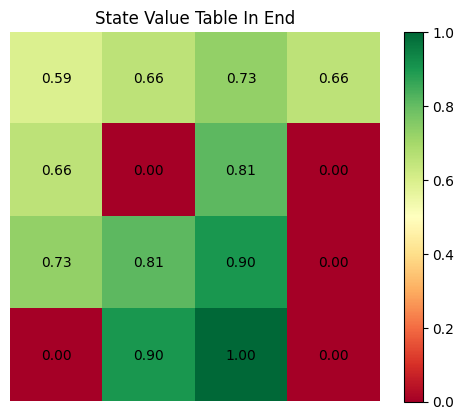

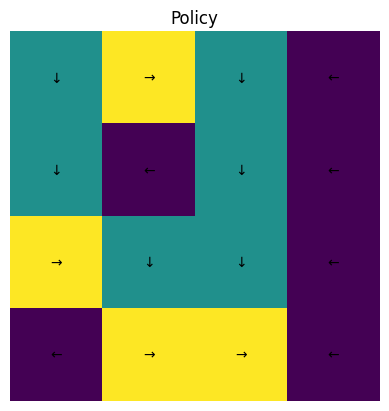

In [9]:
EPISODES=100
times_value_iteration = np.zeros((EPISODES))
excecution_count_value_iteration = np.zeros((EPISODES))
average_state_values = np.zeros((env.observation_space.n))
average_state_qs = np.ones((env.observation_space.n, env.action_space.n))
for episode in range(EPISODES):
    start_time=time.time()
    v=ValueIteration(env=env,discount_factor=0.9)
    v.value_estimation()
    end_time=time.time()
    times_value_iteration[episode]=end_time-start_time
    excecution_count_value_iteration[episode]=v.num_of_steps
    average_state_values+=v.state_values
    average_state_qs+=v.q_values
average_state_values/=EPISODES
average_state_qs/=EPISODES

best_agent=ValueIteration(env=env,discount_factor=0.9)
best_agent.q_values=average_state_qs
    
table_plot_values(average_state_values.reshape((4,4)),"State Value Table In End")
table_plot_policy(best_agent.get_final_policy().reshape((4,4)),"Policy")

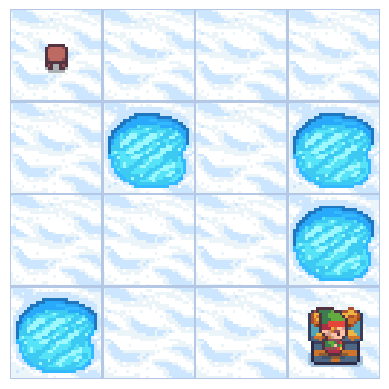

In [10]:
simulate_frozen_lake(best_agent)

The implementation here is the same as above.

<a name='1-3-2'></a>
#### Policy Iteration:

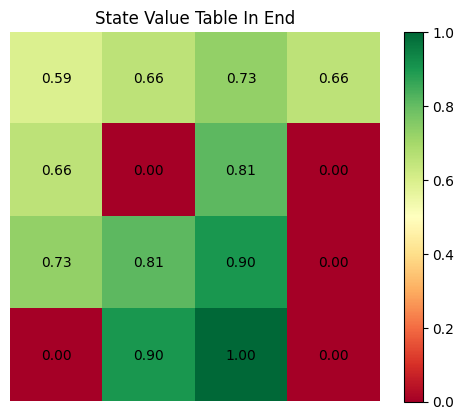

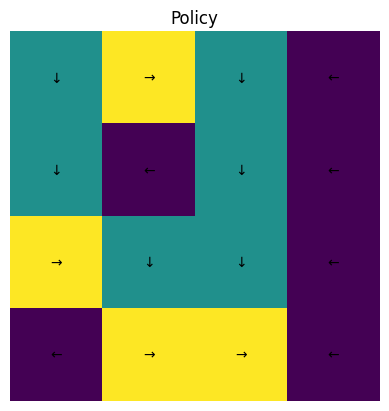

In [11]:
times_policy_iteration = np.zeros((EPISODES))
excecution_count_policy_iteration = np.zeros((EPISODES))
average_state_values = np.zeros((env.observation_space.n))
average_state_qs = np.ones((env.observation_space.n, env.action_space.n))
for episode in range(EPISODES):
    start_time=time.time()
    p=PolicyIteration(env=env,discount_factor=0.9)
    p.policy_estimation()
    end_time=time.time()
    times_policy_iteration[episode]=end_time-start_time
    excecution_count_policy_iteration[episode]=p.num_of_steps
    average_state_values+=p.state_values
    average_state_qs+=p.q_values
average_state_values/=EPISODES
average_state_qs/=EPISODES

best_agent=PolicyIteration(env=env,discount_factor=0.9)
best_agent.q_values=average_state_qs
best_agent.policy_estimation()
    
table_plot_values(average_state_values.reshape((4,4)),"State Value Table In End")
table_plot_policy(best_agent.policy.reshape((4,4)),"Policy")

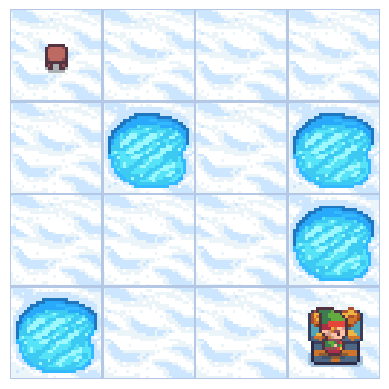

In [12]:
simulate_frozen_lake(best_agent)

<a name='1-4'></a>
### Question 6:

As we can see above the policy is the same for both methods and it should be. although they have the same $V^*$ here but in some cases they may vary .The state values obtained from value iteration and policy iteration may differ due to their different approaches and convergence materials. as we know because the accuracy of the Policy iteration in calculating state values is lower than Value iteration then we might see differences in state values. the other factor is that the convergence material in Policy iteration is policy stability so it might converge when the state values are not that accurate.
So if the environment we are training on was not that simple for the agent and has had more complexity the state values would most likely to be different.

### Convergence time comparison

<a name='1-4-1'></a>
#### Value Iteration:

Value iteration algorithm converges to optimal solution in average 0.04266 seconds
Value iteration algorithm converges to optimal solution in average 141.00 steps


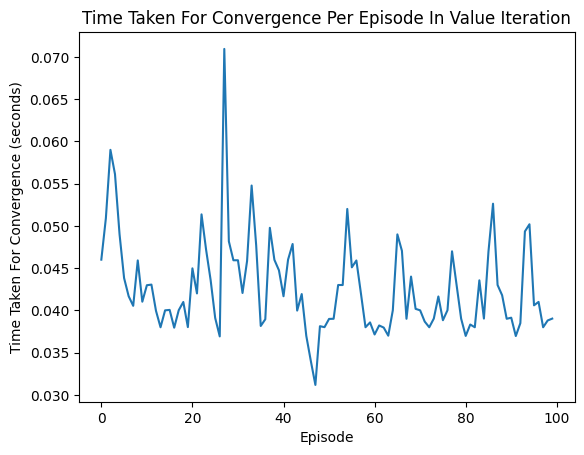

In [13]:
print(f"Value iteration algorithm converges to optimal solution in average {np.mean(times_value_iteration):.5f} seconds")
print(f"Value iteration algorithm converges to optimal solution in average {np.mean(excecution_count_value_iteration):.2f} steps")

plt.plot(range(EPISODES), times_value_iteration)
plt.xlabel('Episode')
plt.ylabel('Time Taken For Convergence (seconds)')
plt.title('Time Taken For Convergence Per Episode In Value Iteration')
plt.show()


<a name='1-4-2'></a>
#### Policy Iteration:

Policy iteration algorithm converges to optimal solution in average 0.01958 seconds
Policy iteration algorithm converges to optimal solution in average 6.30000 steps


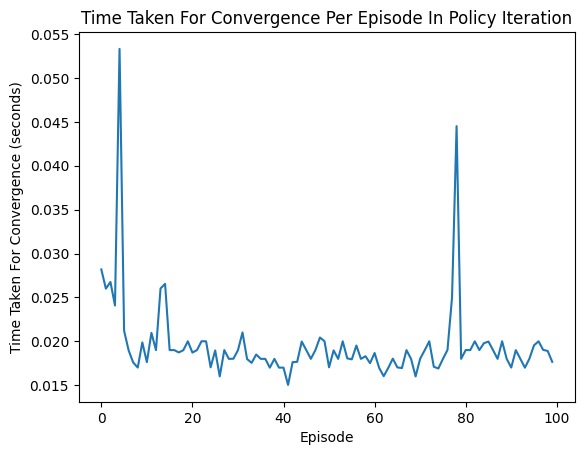

In [14]:
print(f"Policy iteration algorithm converges to optimal solution in average {np.mean(times_policy_iteration):.5f} seconds")
print(f"Policy iteration algorithm converges to optimal solution in average {np.mean(excecution_count_policy_iteration):.5f} steps")

plt.plot(range(EPISODES), times_policy_iteration)
plt.xlabel('Episode')
plt.ylabel('Time Taken For Convergence (seconds)')
plt.title('Time Taken For Convergence Per Episode In Policy Iteration')
plt.show()


In terms of convergence speed, Policy iteration typically converges faster than Value iteration. it's important to note that the number of steps alone doesn't always determine the actual computational time required for convergence. as we can see above the average excecution steps is way smaller in Policy iteration but the average seconds to converge is not that low. as it is obvious each step in Policy iteration is heavier with respect to coputational cost.

# Conclusion
Value iteration and Policy iteration are algorithms for solving MDP problems. they find the optimal policy for navigating the environment and maximizing rewards. both algorithms converge to the optimal policy but the Value iteration takes more time. the choice between them depends on factors such as computational resources and convergence speed and also the accuracy we expect for values at the end.

<a name='2'></a>
## Part 2: Q-Learning Algorithm

In [16]:
# hyperparameters
REPS = 20
EPISODES = 2000
EPSILON = 0.2
LEARNING_RATE = 0.2
DISCOUNT = 0.9
STUDENT_NUM = 231
MAX_EPSILON = 0.5
MIN_EPSILON = 0.01
EPSILON_DECAY_RATE = 1 / EPISODES
MAX_ALPHA = 0.2
MIN_ALPHA = 0.05
ALPHA_DECAY_RATE = 1 / EPISODES

In [17]:
# environment
env = gym.make('Taxi-v3',render_mode="rgb_array")
Initial_State,_ = env.reset(seed = STUDENT_NUM)
Initial_State

271

In [18]:
taxi_row, taxi_col, pass_idx, dest_idx = env.decode(Initial_State)
taxi_row, taxi_col, pass_idx, dest_idx

(2, 3, 2, 3)

you can see the environment in each step by render command :


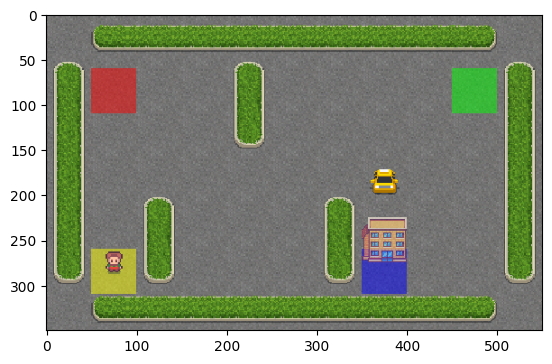

In [19]:
# get familiar with the environment
print("you can see the environment in each step by render command :")
image=env.render()
plt.imshow(image)
plt.show()

In [20]:
# Total no. of states
env.observation_space.n

500

In [21]:
# Total no. of actions
env.action_space.n

6

### Question 7:

Q-learning is a reinforcement learning algorithm used for decision-making in environments with rewards. It estimates the value of taking actions in specific states to learn an optimal policy. The algorithm iteratively updates its estimates based on observed rewards and estimates of future states. This act happens based on 
$$
Q(s, a) = (1-\alpha) Q(s, a) + \alpha \left( R + \gamma \max_{a'}[Q(s', a')] \right)
$$
It balances exploration and exploitation to find the best actions using $\epsilon$ parameter. Q-learning continues updating until it converges to the optimal policy. Then the agent can make decisions based on the highest Q-values for each state.

<a name='2-1'></a>
### Question 8:

### Here i implemented :
- ```chosse_action``` : In this function we choose the right action ( the one with highest $Q$ value) in the specified state by $1-\epsilon$ probability or choose one of the other actions uniformly by $\epsilon$ probability.
- ```update_q_table``` : Here we update the $Q$ table based on the equation introduced above in the specified state, action, nextState and reward.
- ```decay_epsilon``` :  Used for decreasing epsilon in the specified episode.
- ```decrease_learning_rate``` :  Used for decreasing learning rate in the specified episode.

I also added ```q_learning_algorithm``` which runs the algorithm for one episode.

In [22]:
class QLearningAgent():
    def __init__(self, env, epsilon, learning_rate, discount_factor, seed):
      self.env = env
      self.epsilon = epsilon
      self.learning_rate = learning_rate
      self.olr = learning_rate
      self.discount_factor = discount_factor
      self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
      self.seed = seed

    def choose_action(self, state):
      ### START CODE HERE ###
      action=np.argmax(self.q_table[state,:])
      if random.random()<self.epsilon:
        action=random.choice([num for num in range(self.env.action_space.n) if num != action])
      ### END CODE HERE ###
      return action

    def update_q_table(self, state, action, nextState, reward):
      ### START CODE HERE ###
      # Calculate the new Q-value using the Q-learning formula
      self.q_table[state][action] = (1-self.learning_rate)*(self.q_table[state][action]) + \
        (self.learning_rate)*(reward+(self.discount_factor)*np.max(self.q_table[nextState][:]))
      ### END CODE HERE ###

    def decay_epsilon(self, episode):
      ### START CODE HERE ###
      self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-EPSILON_DECAY_RATE * episode)
      ### END CODE HERE ###

    def decrease_learning_rate(self, episode):
      ### START CODE HERE ###
      self.learning_rate = MIN_ALPHA + (MAX_ALPHA - MIN_ALPHA) * np.exp(-ALPHA_DECAY_RATE * episode)
      ### END CODE HERE ###

    def take_action(self, action):
      next_state, reward, done, _, _ = self.env.step(action)
      return next_state, reward, done

    def get_optimal_policy(self, state):
      return np.argmax(self.q_table[state])

    def get_q_values(self):
      return self.q_table

    def reset(self):
      # self.learning_rate = self.olr
      return self.env.reset(seed=self.seed)

    #added by me
    def q_learning_algorithm(self):
      done = False
      curr_state,_ = env.reset(seed = STUDENT_NUM)
      total_reward = 0
      while not done:
        action = self.choose_action(curr_state)
        next_state, reward, done = self.take_action(action)
        total_reward += reward
        self.update_q_table(curr_state,action,next_state,reward)
        curr_state = next_state
        if done:
          break
      
      return total_reward
        

<a name='2-2'></a>
### Question 9:

# train_Q_learning_agent
In this function we calculate the excecutions time and reward in each repetition and each episode. the reward gets back from ```q_learning_algorithm``` function in the agent. then we calculate time using ```time.time()``` . the calculated time is how long does  ```q_learning_algorithm``` takes to return answer or how long it takes to reach the terminal state. the other part is that it finds the best agent based on the ```average_q_table``` variable. in the end we define the ```best_agent``` a Q learning agent with the ```average_q_table``` as its q_table.

In [23]:
def train_Q_learning_agent(learning_rate_reduction=False):

    rewards = np.zeros((REPS,EPISODES))
    excecution_time = np.zeros((REPS,EPISODES))
    average_q_table=np.zeros((env.observation_space.n, env.action_space.n))
    for rep in range(REPS):
        agent=QLearningAgent(env, EPSILON, LEARNING_RATE, 0.9, STUDENT_NUM)
        for episode in range(EPISODES):
            agent.decay_epsilon(episode)
            if learning_rate_reduction : 
                agent.decrease_learning_rate(episode)

            start_time=time.time()
            rewards[rep,episode]=agent.q_learning_algorithm()
            end_time=time.time()
            excecution_time[rep,episode]=end_time-start_time
        average_q_table+=agent.q_table
    
    best_agent= QLearningAgent(env, EPSILON, LEARNING_RATE, 0.9, STUDENT_NUM)
    average_q_table/=REPS
    best_agent.q_table=average_q_table
    return rewards,excecution_time,best_agent
            

### First we train without learning rate reduction

In [24]:
rewards1, excecution_time1 , best_agent_without_learning_rate_reduction = train_Q_learning_agent()

### Now we train with learning rate reduction

In [25]:
rewards2, excecution_time2,best_agent_with_learning_rate_reduction = train_Q_learning_agent(learning_rate_reduction=True)

### Now for comparison

In this part we are using some helper functions defined in ```helper.py``` :
- `plot_mean_values` : gets the rewards and excecution time of both with and without learning rate reductions and plot each reward on top of other one and each time too.

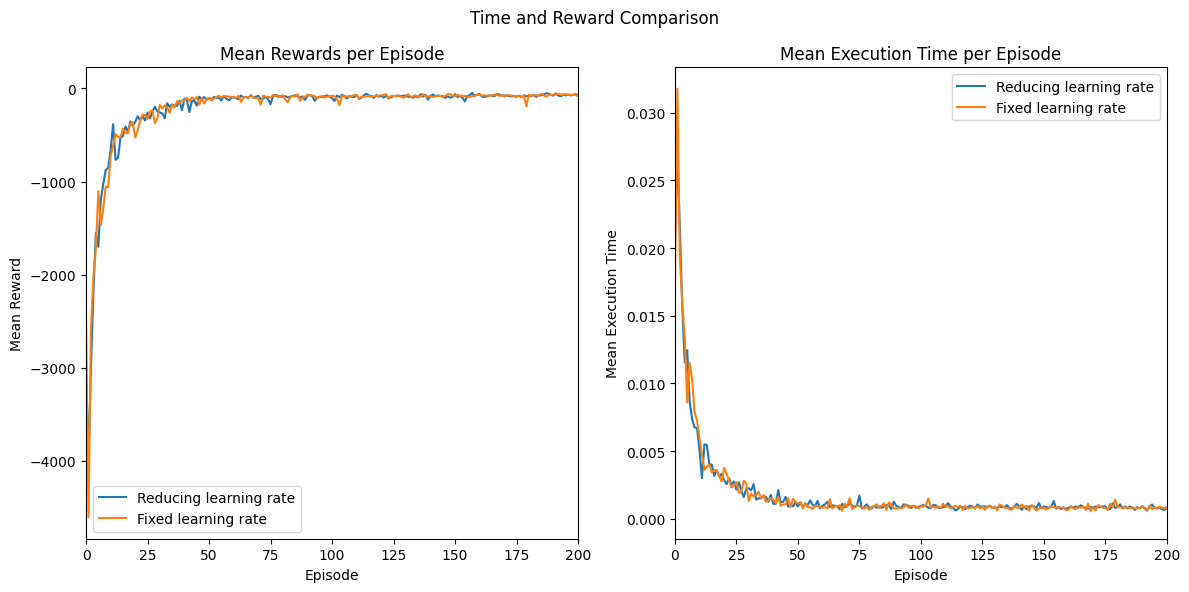

In [26]:
plot_mean_values(rewards2, rewards1, excecution_time2, excecution_time1, "Time and Reward Comparison")

As we can see the rewards converge faster in a decreasing learning rate . Decreasing learning rate allows the algorithm to gradually reduce the step size as it learns more about the environment. This can help the algorithm converge more reliably. By reducing the learning rate over time, the Q-values become less sensitive to immediate updates.

On the other hand the excecution time is better in a reducing learning rate situation. although it might have some overhead for reducing the learning rate but in the end it convergence speed will overcome this overhead.

### Reduction algorithm


We use exponential decay with some modifications . we apply exponential decay to epsilon by using a decay factor or rate. The epsilon value decreases exponentially over time, allowing for a more gradual reduction.  the formula defined below
$$\epsilon = \epsilon_0 \cdot e^{-\text{decay rate} *\text{ episode}}$$

for epsilon decay we use :
$$MIN_\epsilon + (MAX_\epsilon - MIN_\epsilon) \cdot e^{-DECAY\_RATE_\epsilon  *  episode}$$

and for learning rate decay :
$$MIN_\alpha + (MAX_\alpha - MIN_\alpha) \cdot e^{-DECAY\_RATE_\alpha  *  episode}$$
<br>

With these modifications we can control the upper and lower bounds of $\alpha$ and $\epsilon$

<a name='2-3'></a>
### Question 10:

Here we choose the agent with decreasing learning rate for simulation
In this part we are using some helper functions defined in ```helper.py``` :
- `simulate_taxi` : gets the trained agent and simulates it on the environment.

In [27]:
simulate_taxi(best_agent_with_learning_rate_reduction)

The resulting reward is 7


# Conclusion
Q learning is an algorithm used to solve RL problem. It converges to an optimal policy and finds the best actions to maximize rewards. Q learning makes it possible for more exploration with the $\epsilon$ value. Q learning is a model-free algorithm that learns from interactions with environment, making it applicable to various problems.